In [1]:
from ilbal.obia import data_preparation as dp
import numpy as np
import rasterio
from rasterio.plot import show
from skimage.segmentation import felzenszwalb, slic, quickshift
from skimage.future import graph
from skimage import color
import networkx as nx
import matplotlib.pyplot as plt

/home/nate/anaconda3/envs/geo3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
#filename = "/home/nate/Documents/Research/Guatemala/training/training_new_IMG_3833.tif"
filename = "./training/training_new_IMG_3833.tif"

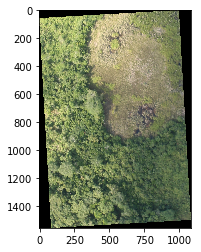

In [4]:
src = rasterio.open(filename)
show(src.read([1,2,3]))

In [3]:
#felz_params = {'scale': 50.0, 'sigma': 2}
slic_params = {'compactness': 15, 'n_segments': 200, 'multichannel': True}
#quickshift_params = {}

In [5]:
# Segment the image using Felzenszwalb.
#rout = dp.segmentation(model=felzenszwalb, params=felz_params, src=src,
#                       modal_radius=3)

In [6]:
# Segment the image using SLIC.
rout = dp.segmentation(model=slic, params=slic_params, src=src,
                       modal_radius=3)
rout = rout + 1

/home/nate/anaconda3/envs/geo3/lib/python3.6/site-packages/skimage/segmentation/slic_superpixels.py:156: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  segments_z = grid_z[slices]
/home/nate/anaconda3/envs/geo3/lib/python3.6/site-packages/skimage/segmentation/slic_superpixels.py:157: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  segments_y = grid_y[slices]
/home/nate/anaconda3/envs/geo3/lib/python3.6/site-packages/skimage/segmentation/slic_superpixels.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprec

In [7]:
# Segment the image using Quickshift.
#rout = dp.segmentation(model=quickshift, params=quickshift_params, src=src,
#                       modal_radius=3)

In [8]:
orig = dp.bsq_to_bip(src.read([1, 2, 3], masked=True))
labels = (dp.bsq_to_bip(rout))[:, :, 0]

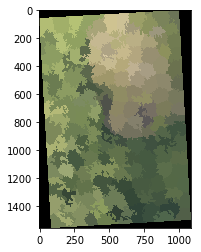

In [9]:
plt.imshow(color.label2rgb(labels, orig, kind='avg'))

In [10]:
vout = dp.vectorize(image=rout, transform=src.transform)
vout.crs = src.crs
vout.to_file("output/original_segs.shp")

In [11]:
len(np.unique(labels))

157

In [12]:
print("Original: " + str(orig.shape) + ", labels: " + str(labels.shape))

Original: (1556, 1086, 3), labels: (1556, 1086)


In [ ]:
# Region Agency Graph to merge segments
rag_sim = graph.rag_mean_color(orig, labels, mode='similarity')
rag_dif = graph.rag_mean_color(orig, labels, mode='distance')

In [ ]:
nx.draw(rag_sim, with_labels=True)

In [ ]:
nx.info(rag_sim)

In [ ]:
nx.density(rag_sim)

In [ ]:
nx.degree_histogram(rag_sim)

In [ ]:
nx.draw(rag_dif, with_labels=True)

In [ ]:
rout_cut_normalized = graph.cut_normalized(labels, rag_sim)
rout_new = graph.cut_threshold(labels, rag_sim, 35)
rout_threshold = graph.cut_threshold(labels, rag_dif, 50)

In [ ]:
cut = np.reshape(rout_cut_normalized, -1)
plt.hist(cut, bins='auto')

In [ ]:
plt.imshow(rout_cut_normalized)

In [ ]:
th = np.reshape(rout_threshold, -1)
plt.hist(th, bins='auto')

In [ ]:
plt.imshow(rout_threshold)

In [ ]:
plt.imshow(rout_new)

In [ ]:
rout3 = dp.bip_to_bsq(rout_threshold[:, :, np.newaxis])
rout3.shape

In [ ]:
len(np.unique(rout3))

In [ ]:
# Vectorize the RAG segments
vout = dp.vectorize(image=rout3, transform=src.transform)
vout.crs = src.crs
print(vout.crs)
vout.to_file("output/working.shp")